In [1]:
import pandas as pd
import numpy as np

from scipy.integrate import odeint
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from pyRothC.RothC import RothC
np.set_printoptions(precision=3,suppress=True )

## RothC 

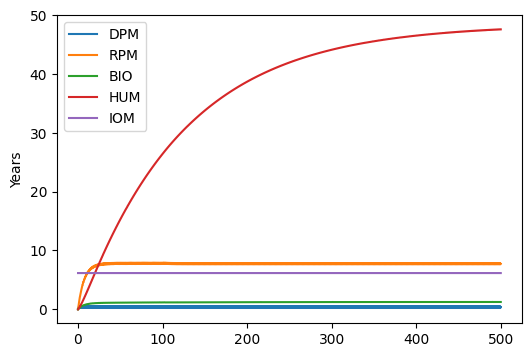

In [2]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
input_carbon=2.7   #Annual C inputs to soil in Mg/ha/yr

IOM=0.049*SOC**(1.139) # Falloon et al. (1998)


rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             C0=np.array([0, 0, 0, 0, IOM]))

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## Pedotranser functions for initial soil conditions

----

Paper: [Weihermueller et al. (2013)](https://bsssjournals.onlinelibrary.wiley.com/doi/pdf/10.1111/ejss.12036?casa_token=_IP4YS2QpN0AAAAA:GTB174qCuWQlDN_5IfvM_j43agtnlIcn4C2i4uG5tsKDZqnksafuCaOywdCfUh_YmI-7xljoCElLkwGqKA)

In [22]:
RPMptf=(0.184*SOC + 0.1555)*(clay + 1.275)**(-0.1158)
HUMptf=(0.7148*SOC + 0.5069)*(clay + 0.3421)**(0.0184)
BIOptf=(0.014*SOC + 0.0075)*(clay + 8.8473)**(0.0567)

DPMptf=SOC-IOM-RPMptf-HUMptf-BIOptf

C0=np.array([DPMptf, RPMptf, BIOptf, HUMptf, IOM])

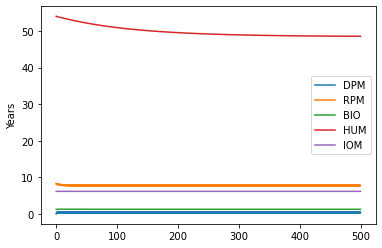

In [23]:
rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48,
             input_carbon=input_carbon,
             pE=1.0,
             C0=C0)

df = rothC.compute()
df.index = rothC.t
fig, ax = plt.subplots(1,1,figsize=(6,4))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')
ax.set_ylabel('Years')
plt.show()

## End

In [16]:
import pandas as pd

df = pd.read_csv('~/Downloads/data.csv')


In [17]:
df

,0,Point,LAT,LON,Moisture_perc_10,Moisture_perc_30,Moisture_perc_80,mean_yeild_c_per_ha,pen_resist_10,pen_resist_30,pen_resist_80,temp_10,temp_30,temp_80
0,K1,1,5751430.197,417003.844,18.93,24.56,17.82,681.7,193.15,210.35,288.85,22.50,18.90,16.30
1,K2,2,5751336.254,416995.506,23.30,24.10,19.49,578.3,106.28,181.38,272.00,20.20,18.30,16.20
2,K3,3,5751240.420,416980.347,23.57,22.89,19.07,626.7,143.37,143.06,292.80,20.60,19.70,17.20
3,K4,4,5751141.626,416976.802,21.36,21.98,17.64,666.7,183.06,325.34,336.20,18.80,17.60,16.00
4,K5,5,5751044.174,416969.528,21.43,20.35,11.15,536.7,119.60,171.37,326.65,20.20,18.90,16.80
5,K6,6,5750943.559,416966.347,20.99,20.13,21.28,731.7,284.85,318.51,385.45,19.30,19.20,15.90
6,K7,7,5751427.601,417098.874,20.23,23.87,21.84,458.3,110.14,200.30,268.10,20.40,18.40,16.00
7,K8,8,5751327.304,417087.221,23.72,22.52,16.67,541.7,99.91,195.36,269.10,20.00,18.10,15.80
8,K9,9,5751226.513,417067.289,20.23,21.64,22.66,796.7,92.20,213.64,324.10,20.10,18.10,15.40
9,K10,10,5751129.808,417048.901,25.35,25.84,18.26,608.3,273.04,294.69,380.90,19.10,17.90,15.70
